In [1]:
# 1. Import thư viện cần thiết
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU
import seaborn as sns

In [6]:
# 2. Đọc file csv và gắn index với giá AQI
df = pd.read_csv('/content/drive/MyDrive/Dataset/QuangNinh.csv')

# Convert the 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'], format='%m/%d/%Y')
df = df[df['date'] < '2024-03-01']

# Create AQI column with the maximum value from the specified columns
df['AQI'] = df[['pm25', 'pm10', 'o3', 'no2', 'so2', 'co']].max(axis=1)

df.head()


,Unnamed: 0,date,pm25,pm10,o3,no2,so2,co,AQI
0,1,2021-02-14,20,6,28,5,12,5,28
1,2,2021-02-15,9,14,28,9,12,5,28
2,3,2021-02-16,18,17,26,9,12,6,26
3,4,2021-02-17,20,24,26,15,12,6,26
4,5,2021-02-18,28,29,38,16,12,6,38


In [7]:
df1 = df.reset_index()['AQI']
# 3. Scaler data
scaler = MinMaxScaler(feature_range=(0, 1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1, 1))

# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

# 5. Hàm Create Dataset
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

# 6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# 8. Define GRU Model
model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# 9. Fit mô hình với dữ liệu train
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1)

# Predict on train and test data
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform predictions
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)


Epoch 1/100
9/9 [==============================] - 3s 120ms/step - loss: 0.0014 - val_loss: 0.0068
Epoch 2/100
9/9 [==============================] - 1s 61ms/step - loss: 8.5450e-04 - val_loss: 0.0066
Epoch 3/100
9/9 [==============================] - 1s 60ms/step - loss: 7.7092e-04 - val_loss: 0.0064
Epoch 4/100
9/9 [==============================] - 1s 59ms/step - loss: 7.0765e-04 - val_loss: 0.0063
Epoch 5/100
9/9 [==============================] - 1s 61ms/step - loss: 6.8277e-04 - val_loss: 0.0062
Epoch 6/100
9/9 [==============================] - 1s 59ms/step - loss: 6.5616e-04 - val_loss: 0.0062
Epoch 7/100
9/9 [==============================] - 0s 56ms/step - loss: 6.3347e-04 - val_loss: 0.0061
Epoch 8/100
9/9 [==============================] - 1s 62ms/step - loss: 6.2599e-04 - val_loss: 0.0061
Epoch 9/100
9/9 [==============================] - 1s 60ms/step - loss: 6.1642e-04 - val_loss: 0.0061
Epoch 10/100
9/9 [==============================] - 1s 93ms/step - loss: 6.0042e-04 -

In [10]:
# 10. Generate future predictions
def predict_future(model, data, time_step, future_days):
    temp_input = data[-time_step:].reshape(1, -1)
    temp_input = list(temp_input[0])
    future_output = []

    for _ in range(future_days):
        if len(temp_input) > time_step:
            temp_input = temp_input[1:]
        input_data = np.array(temp_input).reshape(1, time_step, 1)
        prediction = model.predict(input_data, verbose=0)
        temp_input.append(prediction[0][0])
        future_output.append(prediction[0][0])

    future_output = scaler.inverse_transform(np.array(future_output).reshape(-1, 1))
    return future_output


In [11]:
# Predict for 30, 60, 90 days
future_30_days = predict_future(model, df1, time_step, 30)
future_60_days = predict_future(model, df1, time_step, 60)
future_90_days = predict_future(model, df1, time_step, 90)

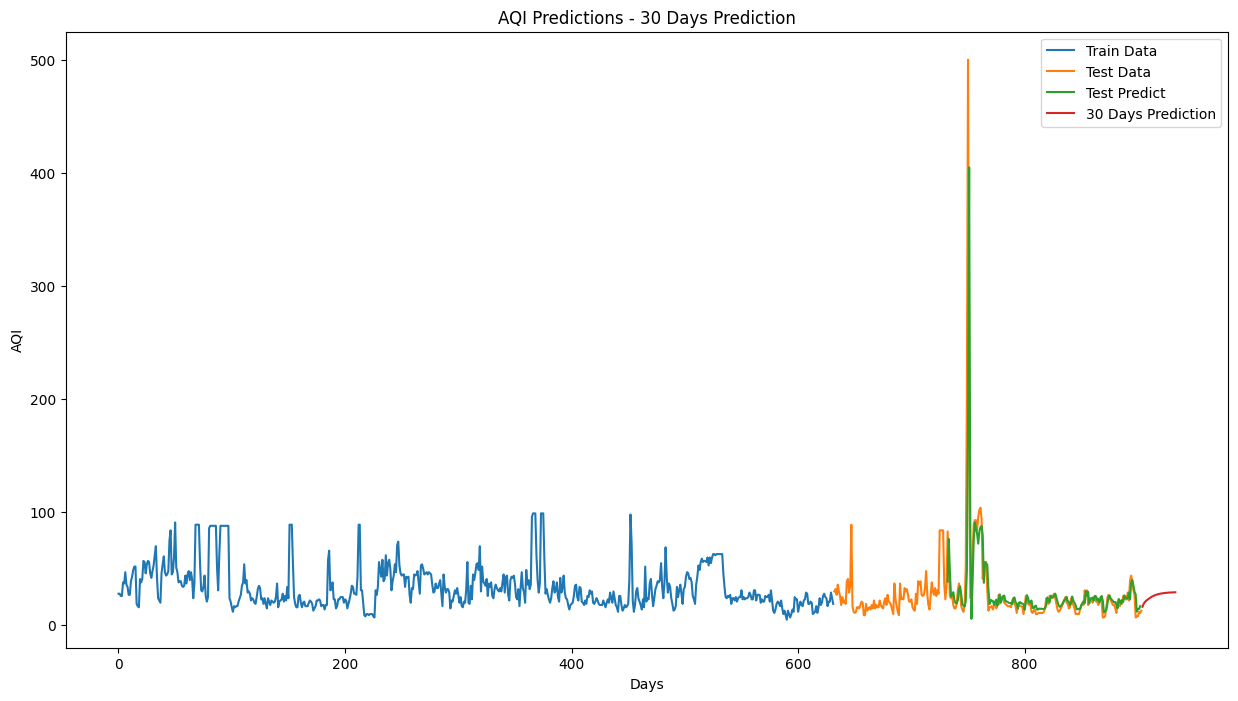

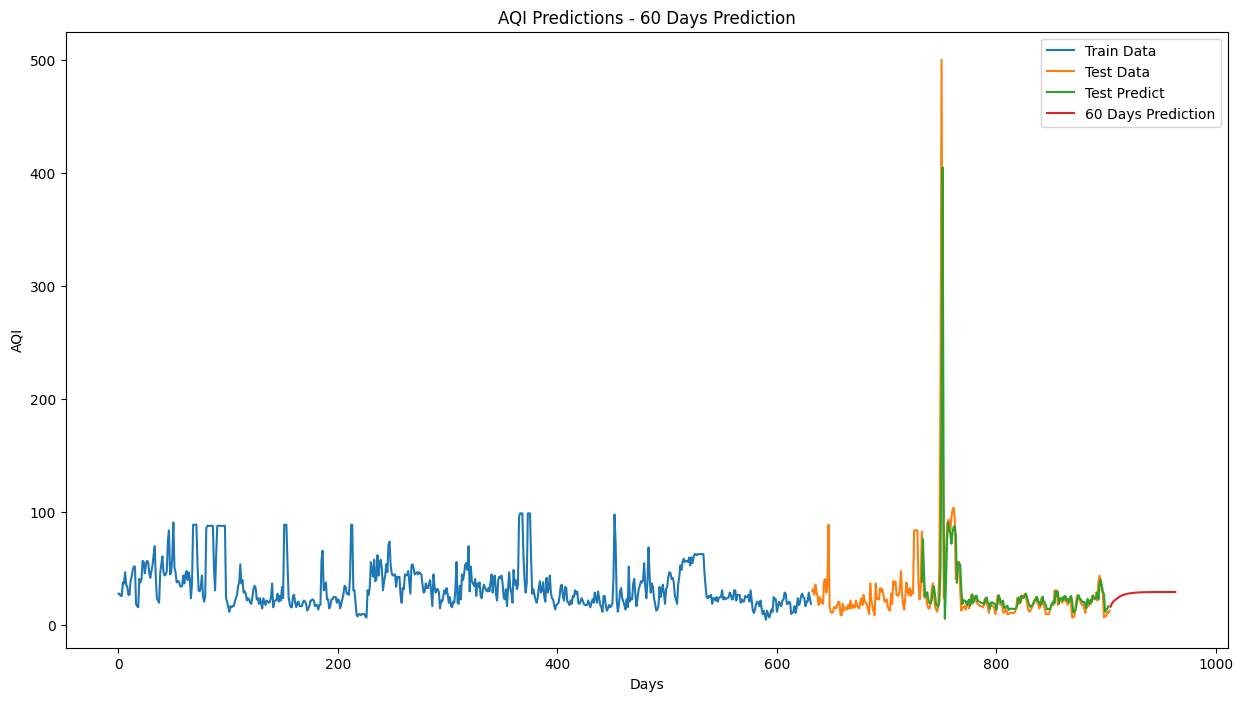

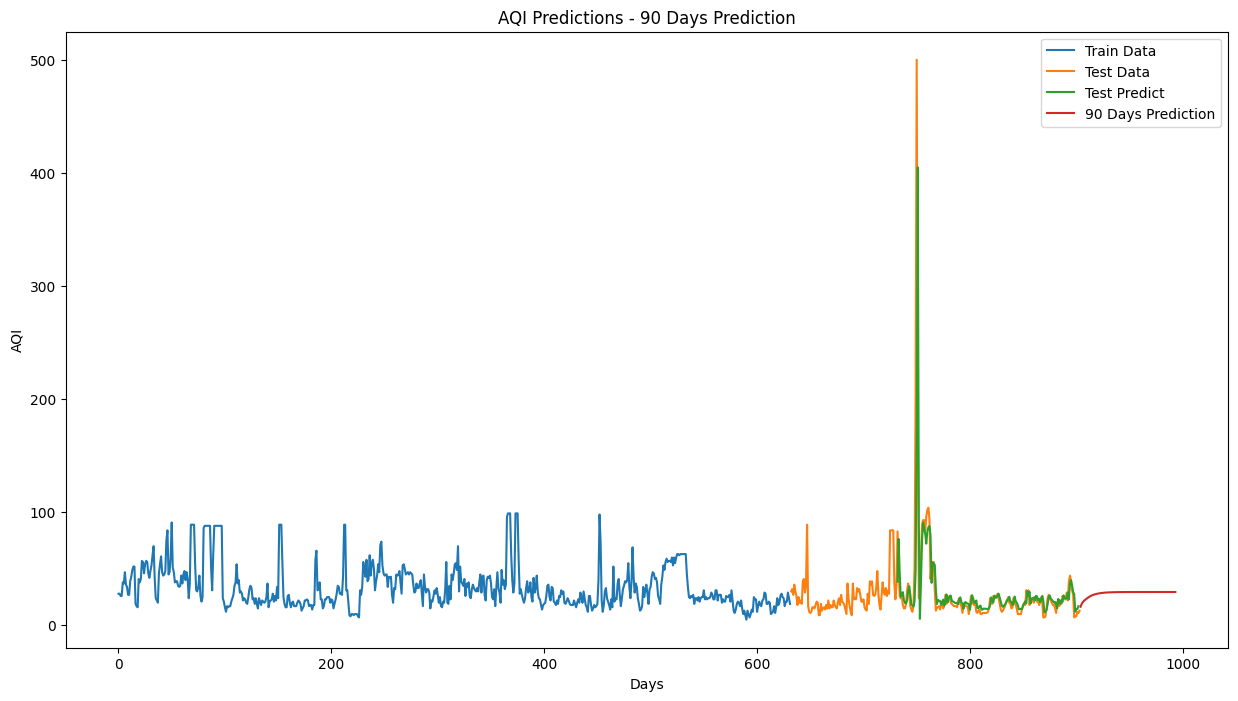

In [12]:


# Function to create and show plots
def create_plot(future_days, future_data, future_label):
    plt.figure(figsize=(15, 8))

    # Plot train data
    plt.plot(scaler.inverse_transform(train_data), label='Train Data')

    # Plot test data
    plt.plot(np.arange(len(train_data), len(train_data) + len(test_data)), scaler.inverse_transform(test_data), label='Test Data')

    # Plot test predictions
    plt.plot(np.arange(len(train_data) + time_step, len(train_data) + time_step + len(test_predict)), test_predict, label='Test Predict')

    # Plot future predictions
    plt.plot(np.arange(len(df1), len(df1) + future_days), future_data, label=future_label)

    # Add labels and legend
    plt.xlabel('Days')
    plt.ylabel('AQI')
    plt.title(f'AQI Predictions - {future_label}')
    plt.legend()
    plt.show()

# Create plots
create_plot(30, future_30_days, '30 Days Prediction')
create_plot(60, future_60_days, '60 Days Prediction')
create_plot(90, future_90_days, '90 Days Prediction')

In [13]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# Calculate MAE, RMSE, and MAPE for test predictions
mae = mean_absolute_error(y_test, test_predict)
rmse = np.sqrt(mean_squared_error(y_test, test_predict))
mape = mean_absolute_percentage_error(y_test, test_predict)

print(f'MAE: {mae}')
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')


MAE: 29.478451070065013
RMSE: 45.67162260846215
MAPE: 900.6929372476603
